/home/ray/miniconda3/envs/learning/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ray/miniconda3/envs/learning/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



MODEL SUMMARY:

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

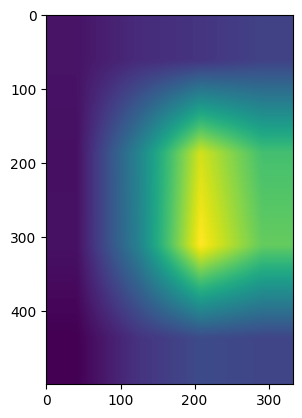

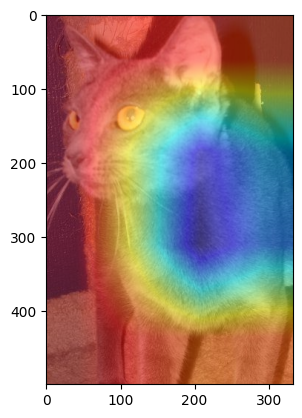

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchvision import transforms
import torchvision
from PIL import Image

from src.gradcam import GradCam, eval_image, get_bdbox_from_heatmap
import matplotlib.pyplot as plt
device = 'cuda'
#)
model = torchvision.models.resnet50(pretrained=True)
    
num_ftrs = model.fc.in_features
n_classes = 2
model.fc = nn.Linear(num_ftrs, n_classes)
model.to(device)

model = model.to(device)

print(f"\nMODEL SUMMARY:\n\n{model}\n")

inputs_ckpt = os.path.join('checkpoints', 'resnet50.pth')

# Load the finetuned model
states = torch.load(inputs_ckpt, map_location=device)
model.load_state_dict(states)

"""
In ResNet 50, layer4 is the last module containing Conv boxes ( after that there is average pooling, fully connected .. )
In this module the layer2 will get us the last conv layer
"""
print(" model : ", model.__dir__())
grad_cam = GradCam(model,  feature_layer=model.layer4, target_layer=['2'], use_cuda=True)
threshold = 0.2
# list images in folder
image_folder_path = 'data/test/test'
images = [os.path.join(image_folder_path, filename) for filename  in  os.listdir(image_folder_path)[:10]]

for image in images:
    # Apply gradcam algorithm on the image
    # In the output of the fully connected layer, the fifth neuron ocrresponds ( after softmax ) to the probability of being an image of a dog
    print("Image : ", image)
    input_img, grayscale_cam, cam, img = eval_image(model, grad_cam, image, target_category=0)

    # Extract all objects from heatmap
    objects = get_bdbox_from_heatmap(grayscale_cam, threshold=threshold)
    #  Loop in each one of the objects and adding it in the detection output
    for obj in objects[::-1]:
        xmin, xmax, ymin, ymax, width, height = obj
        bbox = np.r_[int(xmin), int(ymin), int(xmax), int(ymax)]
    # plot input img and grayscale cam and cam
    # change  input_img shapee from (1, 3, 128, 128) to (128, 128, 3)
    input_img = np.transpose(input_img.squeeze(), (1, 2, 0))
    
    # plt.figure()
    # plt.imshow(input_img)
    plt.figure()
    plt.imshow(grayscale_cam)
    plt.figure()
    plt.imshow(cam)
    break
plt.show()